In [1]:
# PCA(Q_Ques), 통제변수, tpscore, human(engnat, familysize, hand 제외)
# LabelEncoding, Scaling

In [48]:
# 1. 데이터 세팅
# 1) data loading
df1 = pd.read_csv('/Users/harryjeong/python_data/maki_train.csv', index_col = 0) 
df2 = pd.read_csv('/Users/harryjeong/python_data/maki_test_x.csv', index_col = 0)
submission = pd.read_csv('/Users/harryjeong/python_data/sample_submission.csv', index_col = 0)

In [49]:
# 2) labelencoding
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
df1['gender_code'] = label.fit_transform(df1['gender'])
df1['age_group_code'] = label.fit_transform(df1['age_group'])
df1['race_code'] = label.fit_transform(df1['race'])
df1['religion_code'] = label.fit_transform(df1['religion'])

df2['gender_code'] = label.fit_transform(df2['gender'])
df2['age_group_code'] = label.fit_transform(df2['age_group'])
df2['race_code'] = label.fit_transform(df2['race'])
df2['religion_code'] = label.fit_transform(df2['religion'])

# 라벨링한 변수들의 이전 형태는 제거
drop = ['gender','age_group','race','religion']
df1 = df1.drop(drop, axis = 1)
df2 = df2.drop(drop, axis = 1)

In [50]:
# 3) 변수제거1 : Q_Time 제거
# Q_Ques : Q 변수 중 질문만
Q_Ques = ['QaA', 'QbA', 'QcA', 'QdA', 'QeA', 'QfA', 'QgA', 'QhA', 'QiA', 'QjA', 
           'QkA', 'QlA', 'QmA', 'QnA', 'QoA', 'QpA', 'QqA', 'QrA', 'QsA', 'QtA']

# Q_Time : Q 변수 중 소요시간만
Q_Time = ['QaE', 'QbE', 'QcE', 'QdE', 'QeE', 'QfE', 'QgE', 'QhE', 'QiE', 'QkE',
          'QjE', 'QlE', 'QmE', 'QnE', 'QoE', 'QpE', 'QqE', 'QrE', 'QsE', 'QtE']

# scoring 했기에 기존 데이터는 삭제 (Q_Time)
df1 = df1.drop(Q_Time, axis = 1)
df2 = df2.drop(Q_Time, axis = 1)

In [51]:
# 5) 변수제거 2 : W 변수 제거
w_Whole = ['wf_01', 'wf_02', 'wf_03', 'wr_01', 'wr_02', 'wr_03', 'wr_04', 'wr_05', 'wr_06', 'wr_07',
           'wr_08', 'wr_09', 'wr_10', 'wr_11', 'wr_12', 'wr_13']
wf_Ques = ['wf_01', 'wf_02', 'wf_03']
wr_Ques = ['wr_01', 'wr_02', 'wr_03', 'wr_04', 'wr_05', 'wr_06', 'wr_07',
           'wr_08', 'wr_09', 'wr_10', 'wr_11', 'wr_12', 'wr_13']

df1 = df1.drop(w_Whole, axis = 1)    # w_Whole 제거
df2 = df2.drop(w_Whole, axis = 1)    # w_Whole 제거

In [52]:
# 6) 변수제거 3 : hand, familysize 제거 (engnat는 카운트 위에 남겨둠)
df1 = df1.drop(['hand', 'familysize'], axis = 1)     
df2 = df2.drop(['hand', 'familysize'], axis = 1)

In [53]:
# 7) 독립, 종속변수 분리
x = df1.drop('voted', axis = 1)
y = df1['voted']

In [54]:
# 2. 통제변수
# => 인구통계학 같은 행만 모아서 로지스틱 회귀분석
# 1) 변수 뽑아내기
human = ['education', 'engnat', 'married', 'urban', 'gender_code', 'age_group_code',
         'race_code', 'religion_code']

human_df = x[human]

# 인구통계학 변수 통제한 동일행 추출
human_df_1 = human_df.groupby(['education', 'religion_code', 'married', 
                               'urban', 'gender_code', 'age_group_code',
                               'race_code']).count().loc[:, ['engnat']]

# 동일행은 499개
human_df_1[human_df_1['engnat'] == 499]
             
# 동일행이 가지고 있는 각 컬럼의 값    
# education religion_code married urban gender_code age_group_code race_code        
# 2         1             1       2     1           1              6         

# 위 컬럼 값을 대입하여 499개 행을 찾아냄
h_control_index = x.loc[x.education == 2, :].loc[x.religion_code == 1, :].loc[x.married == 1, :].loc[x.urban == 2, :].loc[x.gender_code == 1, :].loc[x.age_group_code == 1, :].loc[x.race_code == 6, :].index.tolist()

In [55]:
human_df_1

engnat
education religion_code married urban gender_code age_group_code race_code        
0         0             1       1     0           1              6               3
                                                  2              6               5
                                                  3              6               3
                                                  4              6               1
                                      1           1              4               1
...                                                                            ...
4         11            2       2     0           2              1               1
                                3     0           4              1               1
                                      1           2              1               1
                                                  4              1               1
                        3       1     1           4              1               1

[6597 rows x 1 columns]

In [16]:
# 2) scaling
from sklearn.preprocessing import StandardScaler as standard
m_sc = standard()
m_sc.fit(x)
x = DataFrame(m_sc.transform(x), columns = x.columns)
df2 = DataFrame(m_sc.transform(df2), columns = df2.columns)

In [17]:
# 3) 전체 데이터에서 499개 행 찾아냄
x_h_control = x.loc[h_control_index, :]
y_h_control = y.loc[h_control_index]

In [18]:
# 4) 499개 행 데이터에서 human 변수 제거
x_h_control = x_h_control.drop(['education', 'religion_code', 'engnat', 
                                'married', 'urban', 'gender_code',
                                'age_group_code', 'race_code'], axis = 1)

x = x.drop(['education', 'religion_code', 'engnat', 'married', 'urban',
            'gender_code', 'age_group_code', 'race_code'], axis = 1)

df2_1 = df2.drop(['education', 'religion_code', 'engnat', 'married', 'urban',
                'gender_code', 'age_group_code', 'race_code'], axis = 1)

In [19]:
# 5) 499개 행 데이터에서 TP~ 변수 제거 for PCA
fea2 = ['tp01','tp02','tp03','tp04','tp05','tp06','tp07','tp08','tp09','tp10']

x_h_control = x_h_control.drop(fea2, axis = 1)
x = x.drop(fea2, axis = 1)
df2_1 = df2_1.drop(fea2, axis = 1)

In [23]:
x_h_control

,QaA,QbA,QcA,QdA,QeA,QfA,QgA,QhA,QiA,QjA,QkA,QlA,QmA,QnA,QoA,QpA,QqA,QrA,QsA,QtA
121,-0.108222,-1.216035,-0.462702,1.198646,-0.232219,-0.124678,0.952880,-0.902214,-0.106424,-1.157452,0.135564,0.587869,-1.09781,-0.429663,-1.501785,-1.390692,0.113603,0.825990,-1.769516,-0.805533
221,-0.943687,0.699521,0.235877,-0.717773,-0.232219,-0.124678,0.952880,-0.902214,0.568465,0.311835,-1.321593,0.587869,0.35661,0.249221,-1.501785,0.623099,0.825689,-0.578142,1.139738,0.508885
431,0.727242,0.699521,0.934456,0.240436,-0.232219,-0.124678,0.952880,1.836017,0.568465,-1.157452,0.864143,0.587869,1.08382,0.928105,1.207512,-1.390692,0.113603,1.528056,0.412424,-0.805533
681,-0.943687,0.699521,0.934456,-0.717773,1.228498,2.099789,-0.371111,0.466901,0.568465,1.046478,0.135564,0.587869,-0.37060,-1.108547,0.530188,1.294363,-1.310567,-1.280208,1.139738,1.166094
682,-0.943687,0.061002,0.235877,-0.717773,0.498140,-0.124678,-0.371111,-0.902214,-1.456203,1.046478,-0.593014,0.587869,1.08382,-1.108547,1.207512,1.294363,-1.310567,-1.280208,1.139738,0.508885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45097,-0.943687,1.338040,0.934456,-0.717773,-0.962578,-0.866167,-1.033107,1.151459,-1.456203,1.046478,-2.050171,0.587869,0.35661,-0.429663,1.207512,1.294363,-1.310567,0.123924,1.139738,1.166094
45102,1.562707,0.699521,0.934456,-0.717773,-0.962578,2.099789,1.614876,1.151459,1.243355,0.311835,0.864143,0.587869,0.35661,1.606989,-1.501785,-1.390692,0.113603,0.825990,0.412424,-1.462741
45167,-0.943687,0.699521,0.235877,0.240436,-0.232219,-0.866167,-0.371111,0.466901,-0.781314,-0.422809,-0.593014,0.587869,0.35661,-0.429663,0.530188,-0.719428,0.113603,-0.578142,0.412424,0.508885
45288,-0.943687,-0.577517,0.934456,-0.717773,0.498140,-0.866167,-1.033107,-0.902214,0.568465,0.311835,0.864143,0.587869,0.35661,0.928105,-1.501785,0.623099,0.113603,0.123924,0.412424,-1.462741


In [20]:
# 3. PCA
# 1) 인공변수 생성
vscore = []
for i in [0.4, 0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95] :
    from sklearn.decomposition import PCA
    m_pca = PCA(n_components = i)                 
    m_pca.fit(x_h_control)                           # 499개의 통제된 데이터의 Q_Ques만 가지고 fitting
    x_pca = m_pca.transform(x)                       # 위 fitting을 전체 Q_Ques에 적용하여 인공변수 뽑아냄
    df2_pca = m_pca.transform(df2_1)                 # df2에도 똑같이 적용
    
    # 2) 인공변수 대입
    # 인공변수만을 가지는 데이터프레임 d1, d2 생성
    s1_columns = np.arange(1, len(x_pca[1]) + 1)
    d1 = DataFrame(x_pca, columns = s1_columns)
    d2 = DataFrame(df2_pca, columns = s1_columns)

    # tpscore, human(engnat, familysize, hand 제외) 컬럼을 가지는 데이터프레임 col1, col2 생성
    col1 = df1.drop(['voted'], axis = 1).drop(Q_Ques, axis = 1).drop('engnat', axis = 1)
    col2 = df2.drop(Q_Ques, axis = 1).drop('engnat', axis = 1)

    c1 = d1.columns.tolist()
    c2 = col1.columns.tolist()
    c3 = c1 + c2

    # d1, d2에 나머지 컬럼데이터 추가
    df1_new = DataFrame(np.hstack([d1, col1]), columns = c3)
    # df1_new['y'] = y => automl용

    df2_new = DataFrame(np.hstack([d2, col2]), columns = c3)    
    
    # 4. RF 모델적용 
    # 1) test, train split
    from sklearn.model_selection import train_test_split
    train_x, test_x, train_y, test_y = train_test_split(df1_new,              
                                                    y,               
                                                    train_size = 0.7, 
                                                    random_state = 0)

    # 2) 모델링
    m_rf = rf(random_state = 0)
    m_rf.fit(train_x, train_y)
    vscore.append(m_rf.score(test_x, test_y))    # 0.6945 (i = 0.6, 6개 차원)

In [25]:
c1

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

In [26]:
c2

['education',
 'married',
 'tp01',
 'tp02',
 'tp03',
 'tp04',
 'tp05',
 'tp06',
 'tp07',
 'tp08',
 'tp09',
 'tp10',
 'urban',
 'gender_code',
 'age_group_code',
 'race_code',
 'religion_code']

In [27]:
vscore

[0.6926061493411421,
 0.6931918008784773,
 0.6945827232796487,
 0.6931185944363104,
 0.6944363103953148,
 0.6892386530014641,
 0.6917276720351391,
 0.6920204978038067,
 0.690117130307467,
 0.6915812591508053]

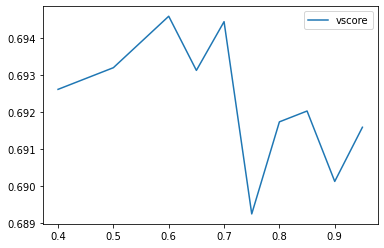

In [28]:
import matplotlib.pyplot as plt
plt.plot([0.4, 0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95], vscore, label = 'vscore')
plt.legend()

In [30]:
# 3) 최적의 차원 개수로 실제 데이터 셋에 적용 및 제출 => 0.85
# 3-1) 인공변수 생성
from sklearn.decomposition import PCA
m_pca = PCA(n_components = 0.6)                 
m_pca.fit(x_h_control)                           # 499개의 통제된 데이터의 Q_Ques만 가지고 fitting
x_pca = m_pca.transform(x)                       # 위 fitting을 전체 Q_Ques에 적용하여 인공변수 뽑아냄
df2_pca = m_pca.transform(df2_1)                 # df2에도 똑같이 적용
    
# 3-2) 인공변수 대입
# 인공변수만을 가지는 데이터프레임 d1, d2 생성
s1_columns = np.arange(1, len(x_pca[1]) + 1)
d1 = DataFrame(x_pca, columns = s1_columns)
d2 = DataFrame(df2_pca, columns = s1_columns)

# tpscore, human(engnat, familysize, hand 제외) 컬럼을 가지는 데이터프레임 col1, col2 생성
col1 = df1.drop(['voted'], axis = 1).drop(Q_Ques, axis = 1).drop('engnat', axis = 1)
col2 = df2.drop(Q_Ques, axis = 1).drop('engnat', axis = 1)

c1 = d1.columns.tolist()
c2 = col1.columns.tolist()
c3 = c1 + c2

# d1, d2에 나머지 컬럼데이터 추가
df1_new = DataFrame(np.hstack([d1, col1]), columns = c3)
# df1_new['y'] = y => automl용
df2_new = DataFrame(np.hstack([d2, col2]), columns = c3)    

# train_test_split
train_x, test_x, train_y, test_y = train_test_split(df1_new, y, random_state= 0)

v_score_te = [] ; v_score_tr = []
for i in range(1, 101) :
    m_rf = rf(random_state = 0, n_estimators = i)
    m_rf.fit(train_x, train_y)
    v_score_tr.append(m_rf.score(train_x, train_y))
    v_score_te.append(m_rf.score(test_x, test_y))
    
max(v_score_te)    # 0.695774
Series(v_score_te).sort_values(ascending = False)    # i = 90일때 best score    

89    0.695774
99    0.695335
85    0.695159
95    0.694984
98    0.694896
        ...   
4     0.647545
3     0.643503
2     0.634279
1     0.611526
0     0.609418
Length: 100, dtype: float64

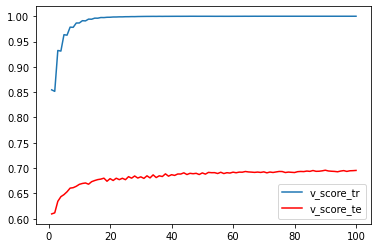

In [31]:
import matplotlib.pyplot as plt
plt.plot(np.arange(1, 101), v_score_tr, label = 'v_score_tr')
plt.plot(np.arange(1, 101), v_score_te, label = 'v_score_te', color = 'red')
plt.legend()    

In [34]:
# RF
m_rf = rf(random_state = 0, n_estimators = 90)
m_rf.fit(df1_new, y)

pred_y = m_rf.predict(df2_new)
submission['voted'] = pred_y

In [35]:
sum(submission['voted'] == 1)

455

In [36]:
sum(submission['voted'] == 2)

10928

In [ ]:
submission.to_csv('sample_submission_PCA2.csv')    # 